In [7]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Results:
    def __init__(self, measure, dataset_name, model_name, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.specific_train_route = specific_train_route
        self.x = x
        self.measure = measure
        self.relative_path = f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv'
        if self.measure == 'FI':
            self.relative_path = f'Results/Separate_Runs/{dataset_name}/{model_name}/*feature_importances365.csv'
        
        self.data = self.data_from_files(self.relative_path, self.measure)
        #if measure == 'Error':
        #    self.data = self.data_from_files_error(self.relative_path, self.measure)
        self.data_route = self.extract_train_routes(specific_train_route, self.data)
    
    def data_from_files(self, relative_path, measure):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(self.x):
                if measure == 'Error':
                    file_dict[f'{measure}_baseline{i}'] = data_from_file[f'{measure}_baseline{i}'][0]
                    file_dict[f'{measure}_ARIMA{i}'] = data_from_file.get(f'{measure}_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = data_from_file[f'{measure}_full{i}'][0]
                else:
                    file_dict[f'{measure}_baseline{i}'] = [data_from_file[f'{measure}_baseline{i}']]
                    file_dict[f'{measure}_ARIMA{i}'] = [data_from_file.get(f'{measure}_ARIMA{i}', [None])] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = [data_from_file[f'{measure}_full{i}']]
                    if measure == 'Predictions':
                        file_dict[f'y_true{i}'] = [data_from_file[f'y_true{i}']]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
        return result_df
    
    def extract_train_routes(self, specific_train_route, data):
        return data[data['route_station'].str.startswith(f'({specific_train_route},')]
    
    def plot_function():
        print('Not implemented...')
    def plot_caller():
        print('Not implemented')
    

In [8]:
from scipy.stats import wilcoxon
class Errors(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Error', dataset_name, model_names, specific_train_route, x)
        
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline0'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(num_predictions):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline0'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA0' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA0'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full0'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.data.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.data_route)

    def median_histogram(self, i=0):
        columns = np.unique([col.split('_')[-1][:-1] for col in self.data.columns if col.startswith('Error')])
        for column_name in columns:
            result_data = self.data[f'Error_{column_name}{str(i)}'] # np.sqrt(result[cv])
            plt.hist(result_data)
            plt.axvline(np.median(result_data), color='red', linestyle='dashed', linewidth=1, label='Median')
            plt.title(f'Error for model={column_name} and i={i}')
            plt.xlabel('MAE')
            plt.ylabel('Occurences')
            plt.legend()
            plt.show()
    
    def wilcoxon_test(self, specific_model='', i=0, alpha=0.05):
        model_columns = [col.split('_')[-1] for col in self.data.columns if col.endswith(str(i))]
        if specific_model:
            print(f'Specific model Comparison: {specific_model}')
            model_columns = ['{}{}'.format(specific_model, j) for j in range(3+1)]


        comparisons = [(model_columns[j], model_columns[k]) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

        result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

        for (model_name1, model_name2) in comparisons:
            differences = np.array(self.data['Error_{}'.format(model_name1)] - self.data['Error_{}'.format(model_name2)])
            rounded_differences = np.round(differences, decimals=5)
            # Perform Wilcoxon signed-rank tests
            statistic, p_value = wilcoxon(rounded_differences)
            if p_value < alpha:
                result_matrix.loc[model_name1, model_name2] = -1
                result_matrix.loc[model_name2, model_name1] = -1
        return result_matrix

In [9]:
ARIMA_XGBoost_Errors = Errors('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_CatBoost_Errors = Errors('Cleaned', 'ARIMA_Catboost', 20)
XGBoost_Errors = Errors('Cleaned', 'XGBoost', 20)
CatBoost_Errors = Errors('Cleaned', 'Catboost', 20)

In [4]:
ARIMA_CatBoost_Errors.data

,route_station,Error_baseline0,Error_ARIMA0,Error_full0,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3
0,"(17, 15)",0.260459,0.150631,0.148070,0.260522,0.167931,0.165783,0.260310,0.173232,0.170795,0.259653,0.183812,0.182414
1,"(21, 4)",0.083350,0.079635,0.078935,0.083419,0.081044,0.079718,0.083522,0.082095,0.080854,0.083833,0.083731,0.081754
2,"(15, 20)",0.104384,0.100816,0.099769,0.104304,0.106803,0.105512,0.104432,0.104600,0.103461,0.104243,0.105249,0.104060
3,"(2, 0)",0.124014,0.113494,0.108597,0.124172,0.126755,0.121194,0.124307,0.129872,0.123456,0.124595,0.129937,0.121840
4,"(11, 27)",0.122147,0.106281,0.106413,0.122116,0.110769,0.112285,0.122195,0.111257,0.112656,0.121967,0.112280,0.113325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"(5, 39)",0.215495,0.123334,0.120400,0.215655,0.134085,0.131570,0.215754,0.141070,0.137441,0.215204,0.146585,0.143243
65,"(11, 16)",0.069131,0.065024,0.064759,0.069130,0.069239,0.068624,0.069100,0.068661,0.067297,0.068895,0.069377,0.068108
66,"(19, 17)",0.172615,0.111600,0.109330,0.173143,0.126694,0.124737,0.173461,0.133075,0.130910,0.174012,0.138451,0.136233
67,"(18, 22)",0.137017,0.113663,0.111398,0.137047,0.119912,0.116853,0.137040,0.122010,0.120039,0.137162,0.124168,0.121606


### Test wilcoxon

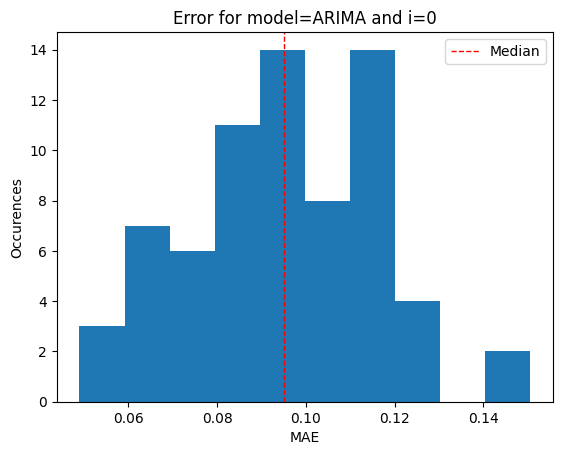

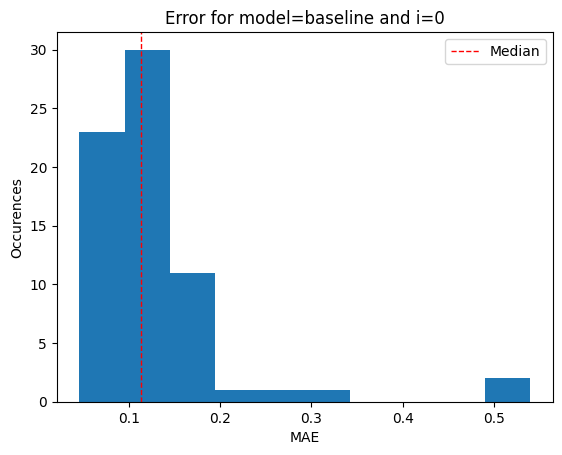

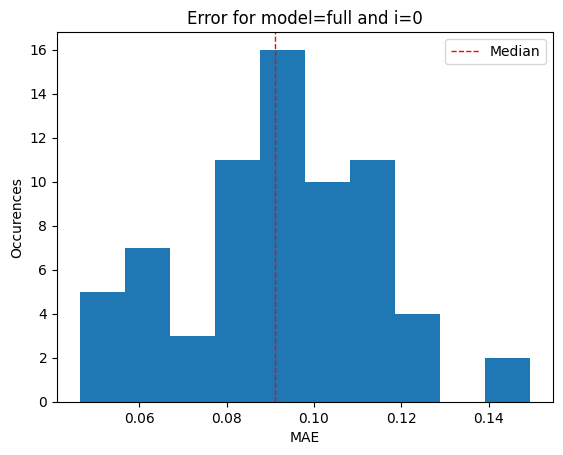

In [5]:
ARIMA_CatBoost_Errors.median_histogram(i=0)

In [6]:
ARIMA_CatBoost_Errors.wilcoxon_test(i=3, specific_model='full')

Specific model Comparison: full


,full0,full1,full2,full3
full0,NaN,-1,-1,-1
full1,-1,NaN,-1,-1
full2,-1,-1,NaN,-1
full3,-1,-1,-1,NaN


### Error plots

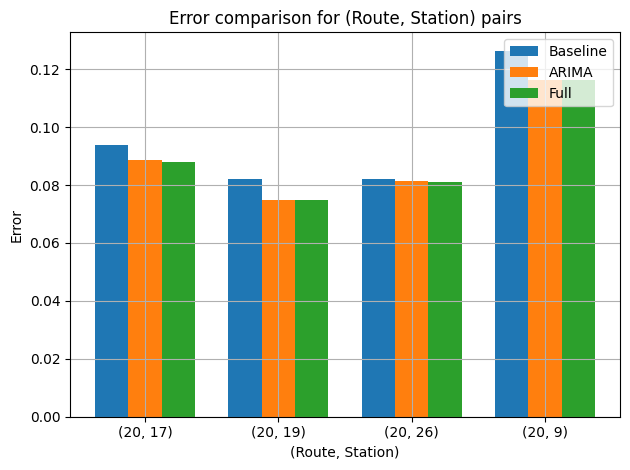

In [7]:
ARIMA_CatBoost_Errors.error_function()

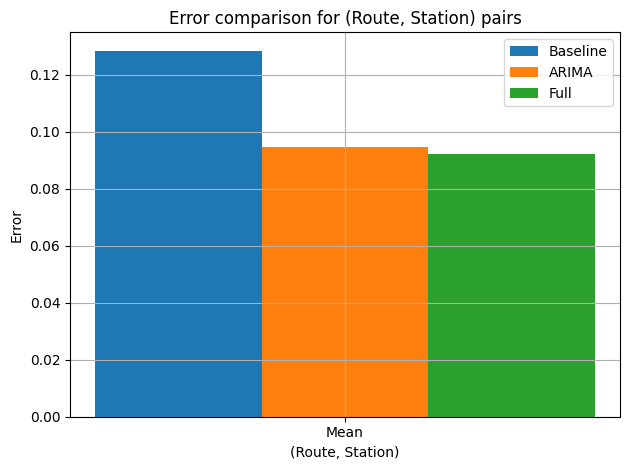

In [8]:
ARIMA_CatBoost_Errors.error_function(use_mean=True)

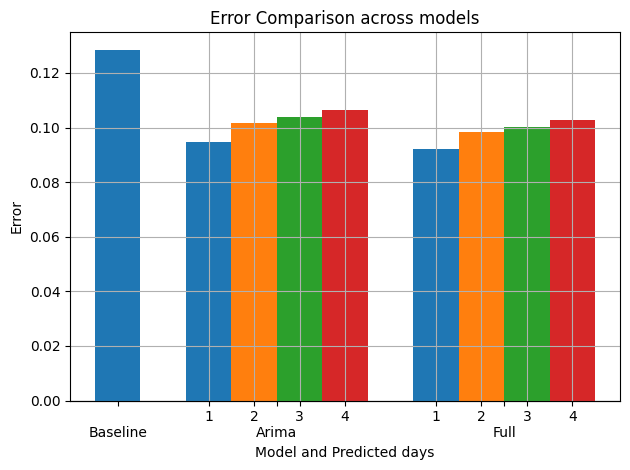

In [9]:
ARIMA_CatBoost_Errors.error_function(use_across_days=True)

In [10]:
def plot_columns(data_classes, column, column_arima=None):
    datasets = data_classes

    plt.figure(figsize=(10,7))
    bar_width = 0.15
    arima_found=False
    plt.bar([bar_width], (pd.DataFrame(datasets[0].data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean'))['Error_baseline0'], bar_width, label='Baseline')
    counter = 0
    for i, (dataset) in enumerate(datasets):
        dataset_df = (pd.DataFrame(dataset.data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')).sort_values(by='route_station')
        plt.bar([(counter+2) * bar_width], dataset_df[column].values, bar_width, label=dataset.model_name)
        counter += 1
        if column_arima in dataset_df.columns and not arima_found:
            plt.bar([(counter+2) * bar_width], dataset_df[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([counter * bar_width-bar_width], dataset_df['route_station'])
    
    plt.legend()
    plt.title(f'Error full on {dataset.dataset_name} data')
    plt.grid()


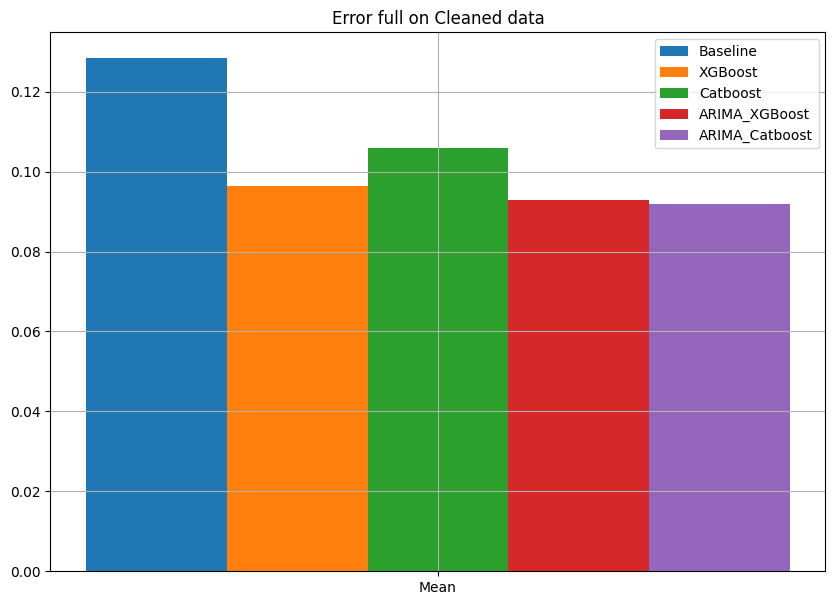

In [11]:
plot_columns([XGBoost_Errors, CatBoost_Errors, ARIMA_XGBoost_Errors, ARIMA_CatBoost_Errors], 'Error_full0', column_arima='Errors_ARIMA0')

In [12]:
XGBoost_Errors_Cleaned = Errors('Cleaned', 'XGBoost', 20)
XGBoost_Errors_Cleaned_lagged = Errors('Cleaned_lagged', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple = Errors('Cleaned_simple', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple_lagged = Errors('Cleaned_simple_lagged', 'XGBoost', 20)

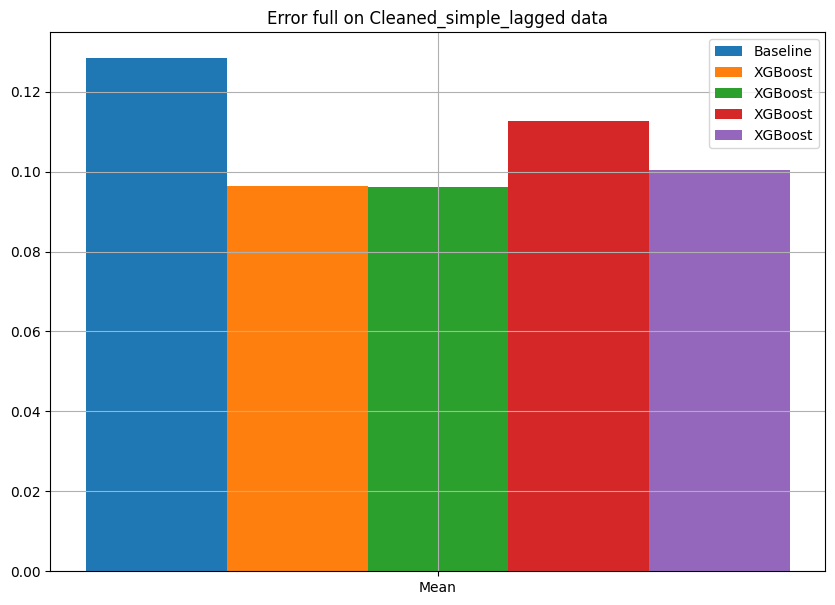

In [13]:
# Across datasets. Pænere potentielt!
plot_columns([XGBoost_Errors_Cleaned, XGBoost_Errors_Cleaned_lagged, XGBoost_Errors_Cleaned_simple, XGBoost_Errors_Cleaned_simple_lagged], 'Error_full0')

In [14]:
from matplotlib.ticker import MaxNLocator
import ast

class CV_score(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('CV_score', dataset_name, model_names, specific_train_route, x)

    def CV_score_histplot(self, i=0, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        for _, row in data.iterrows():
            route_station = ast.literal_eval(row['route_station'])
            cv_scores_full = row[f'CV_score_full{i}']
            cv_scores_baseline = row[f'CV_score_baseline{i}']
            cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
            max_score = max(max(cv_scores_baseline), max(cv_scores_full))
            min_score = min(min(cv_scores_baseline), min(cv_scores_full))
            
            arima_check = not cv_scores_arima.empty

            if arima_check:
                max_score = max(max_score, max(cv_scores_arima))
                min_score = min(min_score, min(cv_scores_arima))
            
            num_bins = 15
            bins = np.linspace(min_score, max_score, num_bins)
            
            plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.5, label='Baseline')
            
            if arima_check:
                plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.5, label='ARIMA')
            
            plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.5, label='Full')

            plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
            plt.xlabel('MAE')
            plt.ylabel('Occurrences')
            plt.legend(loc='upper right')
            plt.grid()
            plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
            plt.show()
        
    def CV_score_lineplot(self, i=0, use_extracted=True, initial_start=30):
            data = self.data
            if use_extracted: data = self.data_route
            for _, row in data.iterrows():
                route_station = ast.literal_eval(row['route_station'])
                cv_scores_full = row[f'CV_score_full{i}']
                cv_scores_baseline = row[f'CV_score_baseline{i}']
                cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
                plt.plot(cv_scores_baseline[-initial_start:], label='Baseline')
                
                if not cv_scores_arima.empty:
                    plt.plot(cv_scores_arima[-initial_start:], label='ARIMA')

                plt.plot(cv_scores_full[-initial_start:], label='Full')
                
                plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
                plt.xlabel('Data points')
                plt.ylabel('MAE')
                plt.legend(loc='upper right')
                plt.grid()
                plt.show()
    def CV_score_function(self, use_hist=False, use_line=False, use_extracted=True, initial_start=30):
        if use_hist:
            self.CV_score_histplot(use_extracted = use_extracted)
        if use_line:
            self.CV_score_lineplot(use_extracted=use_extracted, initial_start=initial_start)
        

In [15]:
ARIMA_XGBoost_CV_scores = CV_score('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_XGBoost_CV_scores.data['CV_score_baseline0']

0     0      0.110337
1      0.099270
2      0.10821...
1     0      0.079962
1      0.026925
2      0.21708...
2     0      0.284660
1      0.126515
2      0.31345...
3     0      0.116897
1      0.088844
2      0.12280...
4     0      0.068392
1      0.068360
2      0.16267...
                            ...                        
64    0      0.020442
1      0.080433
2      0.03139...
65    0      0.045494
1      0.118473
2      0.02658...
66    0      0.046070
1      0.054049
2      0.11002...
67    0      0.092807
1      0.092765
2      0.01572...
68    0      0.039797
1      0.039779
2      0.08523...
Name: CV_score_baseline0, Length: 69, dtype: object

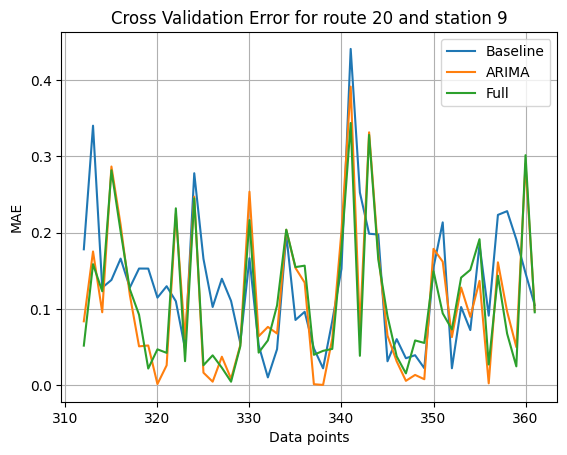

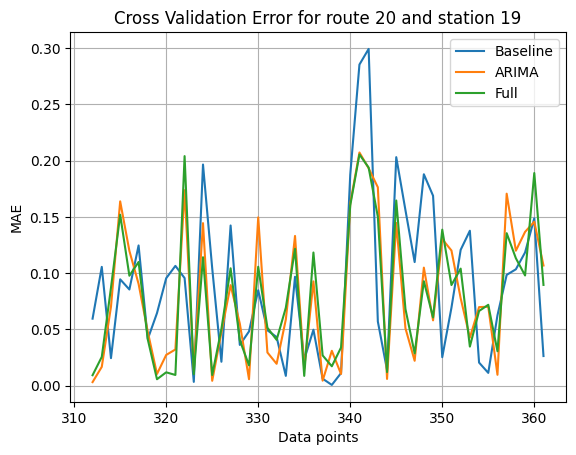

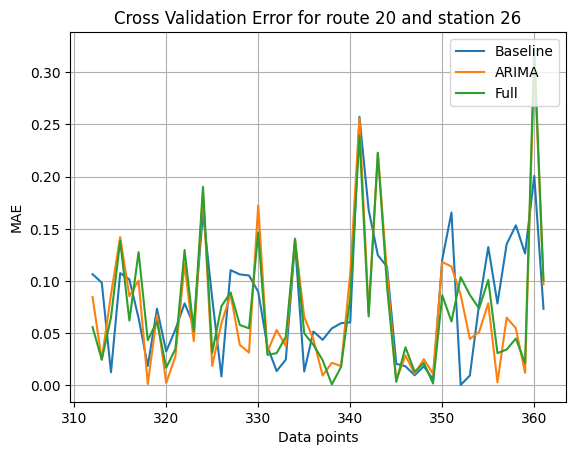

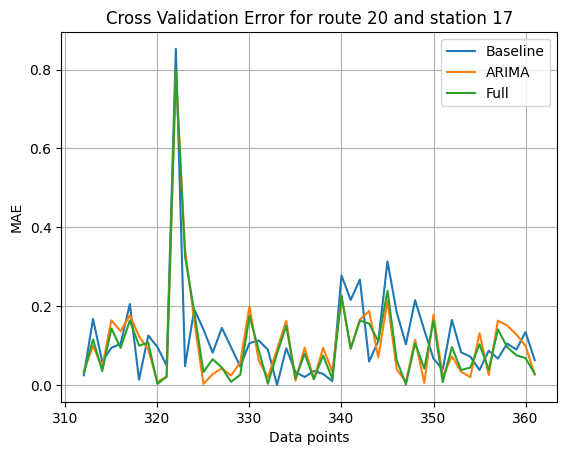

In [16]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_line=True, initial_start=50)

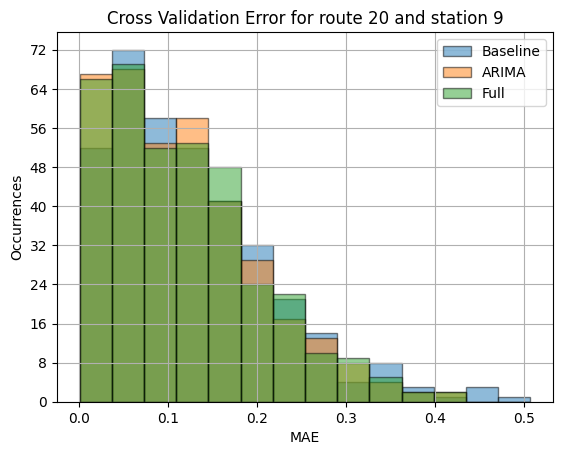

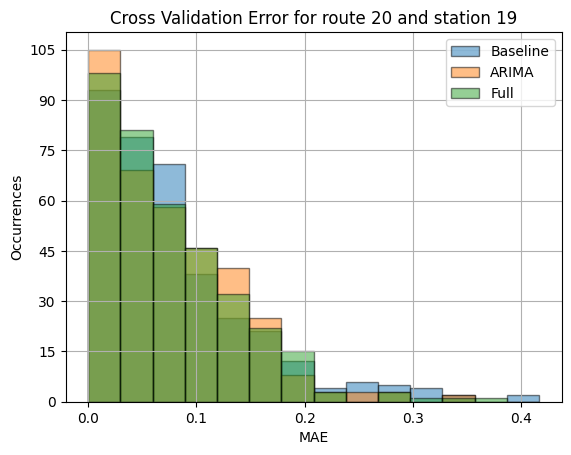

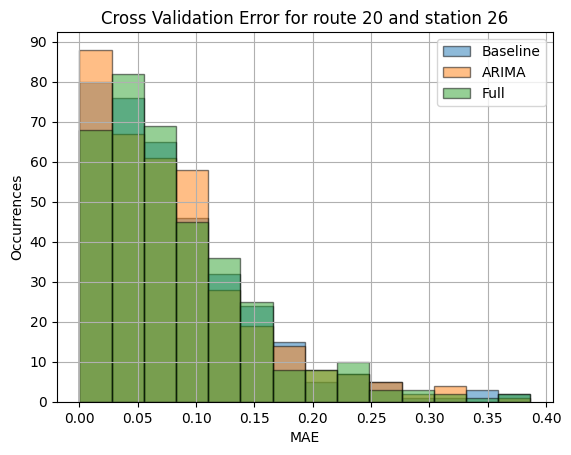

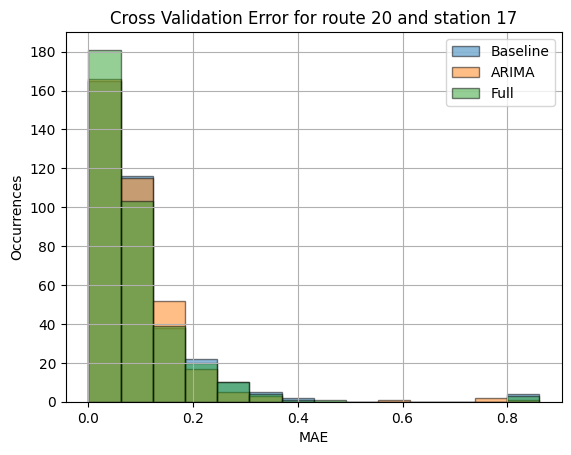

In [17]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_hist=True)

In [18]:
class Predictions(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Predictions', dataset_name, model_names, specific_train_route, x)

    def prediction_plot(self, i, initial_start, arima=False, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        initial_start = initial_start
        for row_no, row in data.iterrows():
            y_test = row[f'y_true{i}']
            # Extract corresponding predictions from predictions DataFrame
            predictions_full = row[f'Predictions_full{i}']
            # Dates: 
            x_dates = np.arange(initial_start)
            route_station = row['route_station']
            plt.plot(x_dates[-initial_start:], y_test[-initial_start:], color='#33a02c', label='Test Data')
            if arima:
                predictions_arima = row.get(f'Predictions_ARIMA{i}', [None])
                plt.plot(x_dates[-initial_start:], predictions_arima[-initial_start:], color='#1E77B4', marker='x', label='ARIMA Predictions')
            plt.plot(x_dates[-initial_start:], predictions_full[-initial_start:], color='#FD7E0E', marker='x', label='Full Predictions')
            plt.title(f'Route/station {route_station}: Predictions & True Value')
            plt.xlabel('Observations')
            plt.ylabel('Train punctuality')
            plt.xticks(x_dates[-initial_start::10], rotation=45)
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()
    def prediction_function(self, i, initial_start, arima, use_extracted):
        self.prediction_plot(i, initial_start, arima, use_extracted)

In [19]:
ARIMA_XGBoost_Predictions = Predictions('Cleaned', 'ARIMA_XGBoost', 20)
#ARIMA_XGBoost_Predictions.data

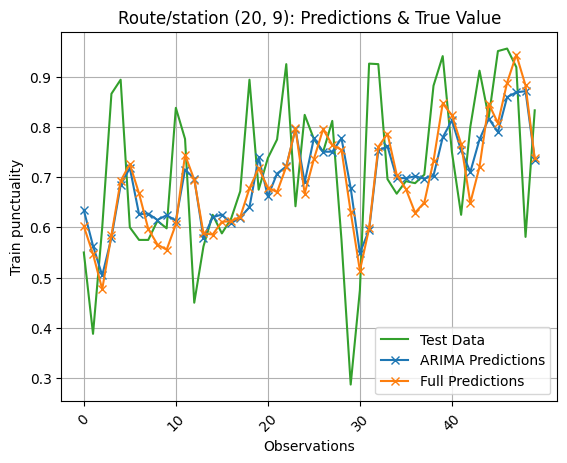

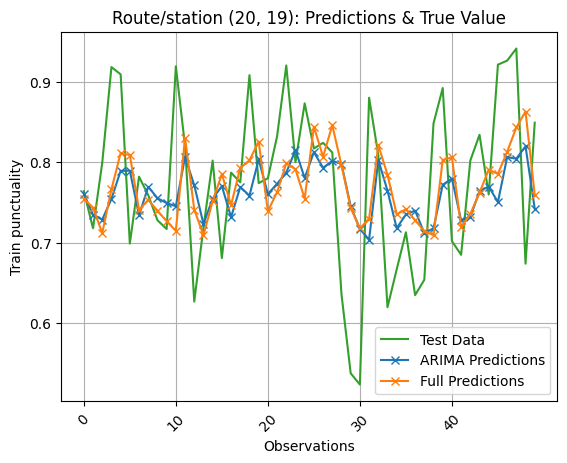

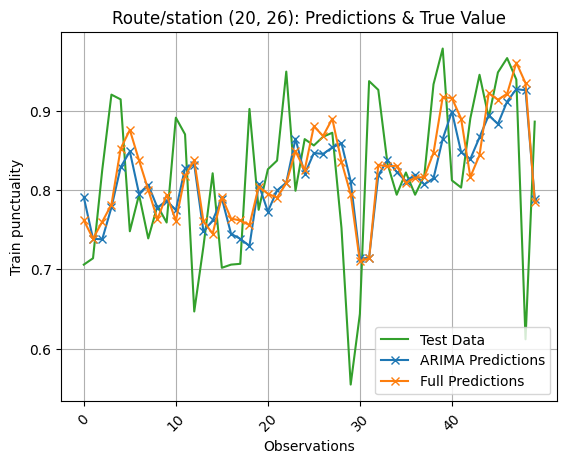

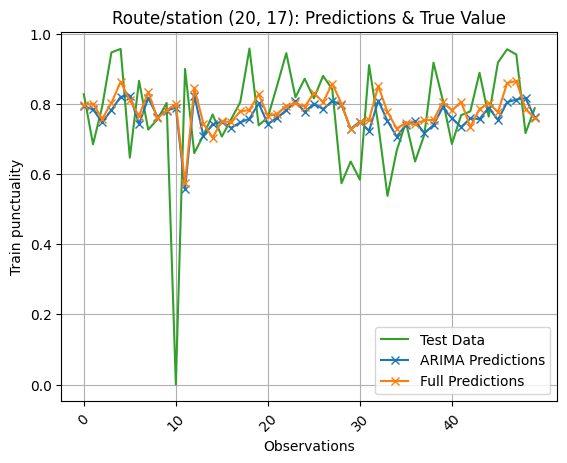

In [20]:
ARIMA_XGBoost_Predictions.prediction_function(i=0, initial_start=50, arima=True, use_extracted=True)

In [65]:
import shap
import textwrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator



class FeatureImportance(Results):
      def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
         super().__init__('FI', dataset_name, model_names, specific_train_route, x)
         self.dataset = pd.read_csv(f'Data/{self.dataset_name}_data.csv')

         self.mean_matrix_all = self.mean_matrix_calculation()
         self.mean_matrix_route = self.mean_matrix_calculation(use_extracted=True)
         self.feature_importance_path = f'Results/SHAP_consistency/{dataset_name}/{model_names}/*feature_importances365.csv'
         self.data_consistency = self.data_from_files_consistency()
         if len(self.data_consistency) != 0:
               self.mean_matrix_consistency = self.mean_matrix_calculation_consistency()

      def data_from_files(self, relative_path, measure):
            file_list_results = glob.glob(relative_path)
        
            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(relative_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df
      
      def data_from_files_consistency(self):
            file_list_results = glob.glob(self.feature_importance_path)

            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(self.feature_importance_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0] + file[index_start:].split('_')[1][-1]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df

      
      def mean_matrix_calculation(self, use_extracted = False):
            data = self.data
            if use_extracted:
                  data = self.data_route
            mean_matrix = np.zeros(data.iloc[0,1].shape)
            for i in range(0,len(data)):
                  mean_matrix += data.iloc[i,1]
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix
      
      def mean_matrix_calculation_consistency(self):
            data = self.data_consistency
            mean_matrix = np.zeros((data.iloc[0,1].shape[0], data.iloc[0,1].shape[1], 6))
            for i in range(0,len(data)):
                  period = int(data.iloc[i,0][-1])
                  mean_matrix[:,:,period] += data.iloc[i,1]
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix

      def plot_consistency1(self):
            periods = [f'20{17+i}'for i in range(6)]
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix=np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns,new_mean_matrix)),columns=['col_name','feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
                  plt.barh(feature_importance.iloc[:10,0].values, feature_importance.iloc[:10,1].values, label=periods[i])
                  plt.xticks(rotation=-45)
                  plt.legend()
                  plt.grid()
                  plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

                  #self.plot_shap_summary(new_mean_matrix=self.mean_matrix_consistency[:,:,i])
            #plt.show()

      def plot_consistency(self):
            periods = [f'20{17+i}' for i in range(6)]
            top_features = []

            # Extract top 10 features for each period
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix = np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns, new_mean_matrix)), columns=['col_name', 'feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
                  top_features.append(feature_importance.iloc[:10, 0].values)

            # Create a DataFrame to store the presence of top features across periods
            feature_presence = pd.DataFrame(index=np.unique(np.concatenate(top_features)), columns=periods)
            feature_presence = feature_presence.fillna(0)

            # Update the presence matrix with placement
            for i, features in enumerate(top_features):
                  for rank, feature in enumerate(features):
                        feature_presence.loc[feature, periods[i]] = rank + 1  # Rank starts from 1
            # Create custom colormap with white for 0, dark for 1, and brighter colors for higher ranks
            cmap_colors = [(0.5, 0.5, 1)]  # White color for 0
            for i in range(11, 1, -1):
                  brightness = 1 - (i / 11)  # Calculate brightness (0 for rank 1, 1 for rank 10)
                  cmap_colors.append((brightness, brightness, 1))  # Blueish color with varying brightness
            cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

            # Plot heatmap with actual placement
            plt.figure(figsize=(10, 8))
            sns.heatmap(feature_presence, cmap=cmap, annot=True, cbar=True, center=5, fmt= ".0f", mask=(feature_presence == 0))
            plt.title('Top Features Across Time Periods')
            plt.xlabel('Time Period')
            plt.ylabel('Top Features')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
      
      def plot_shap_summary(self, plot_type='dot', new_mean_matrix=None, use_extracted = False):
            shap_values = self.mean_matrix_all
            if use_extracted:
                  shap_values = self.mean_matrix_route
            if new_mean_matrix is not None:
                  shap_values = new_mean_matrix

            data_used = self.dataset.iloc[-len(shap_values)-3:-3, 2:] # used only the 365 last datapoints and not the last 3 ones because horizon = 4, columns excluded are date and train punctuality
            shap.summary_plot(shap_values, data_used, show=False, max_display=10, plot_type=plot_type, plot_size=(0.1,16)) #  feature_names=np.array(feature_names).reshape(211,1)
            plt.gcf().set_size_inches(18, 10)

            ax = plt.gca()
            tick_labels = ax.get_yticklabels()
            # Wrap long tick labels to the next line
            max_chars_per_line = 23  # Define the maximum number of characters per line
            wrapped_tick_labels = []
            for label in tick_labels:
                  text = label.get_text()
                  # Find the nearest underscore within the specified range
                  underscore_index = min(max_chars_per_line, len(text))  # Initialize with max_chars_per_line
                  for i in range(max_chars_per_line - 5, len(text)):
                        if text[i] == '_':
                              underscore_index = i
                              break
                  wrapped_tick_labels.append(textwrap.fill(text, underscore_index+1))

            # Set the wrapped tick labels
            ax.set_yticklabels(wrapped_tick_labels[:len(shap_values)])  # Ensure the number of labels matches the number of shap values


            plt.yticks(fontsize = 12)
            plt.xticks(fontsize=12)
            plt.show()

In [66]:
FI_Cleaned_lagged_ARIMA_XGBoost = FeatureImportance('Cleaned_lagged', 'XGBoost', 20)
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_all.shape

(362, 275)

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_2256/823945825.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_presence = feature_presence.fillna(0)


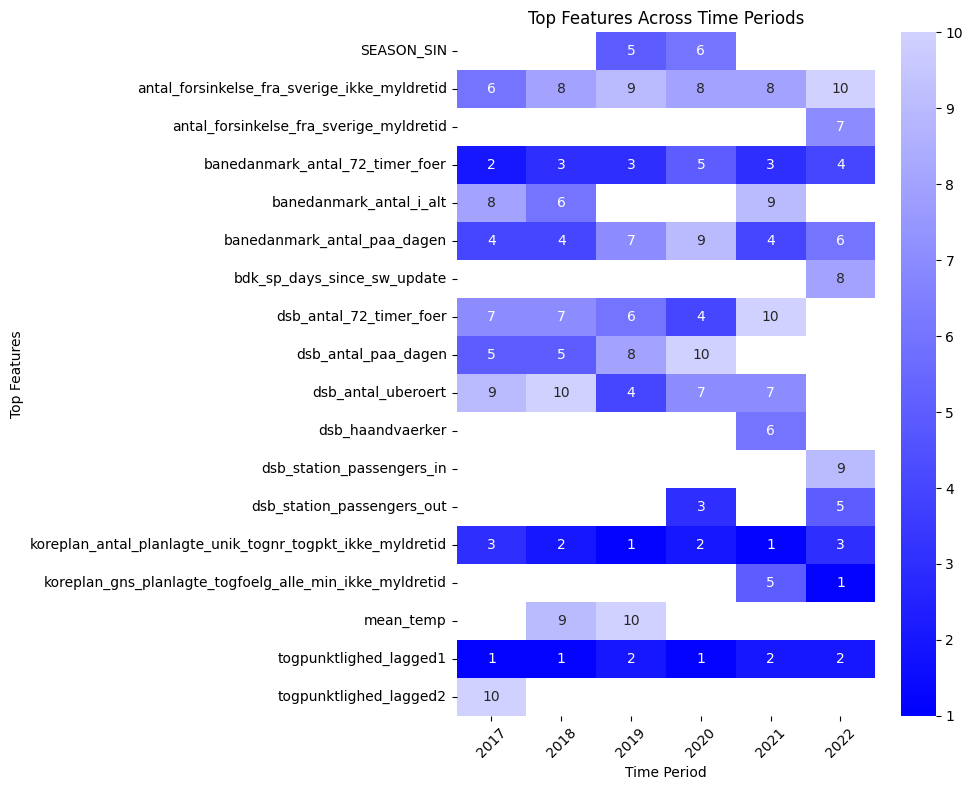

In [67]:
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency.shape
FI_Cleaned_lagged_ARIMA_XGBoost.plot_consistency()

In [55]:
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency[:,:,0].shape

(365, 275)

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


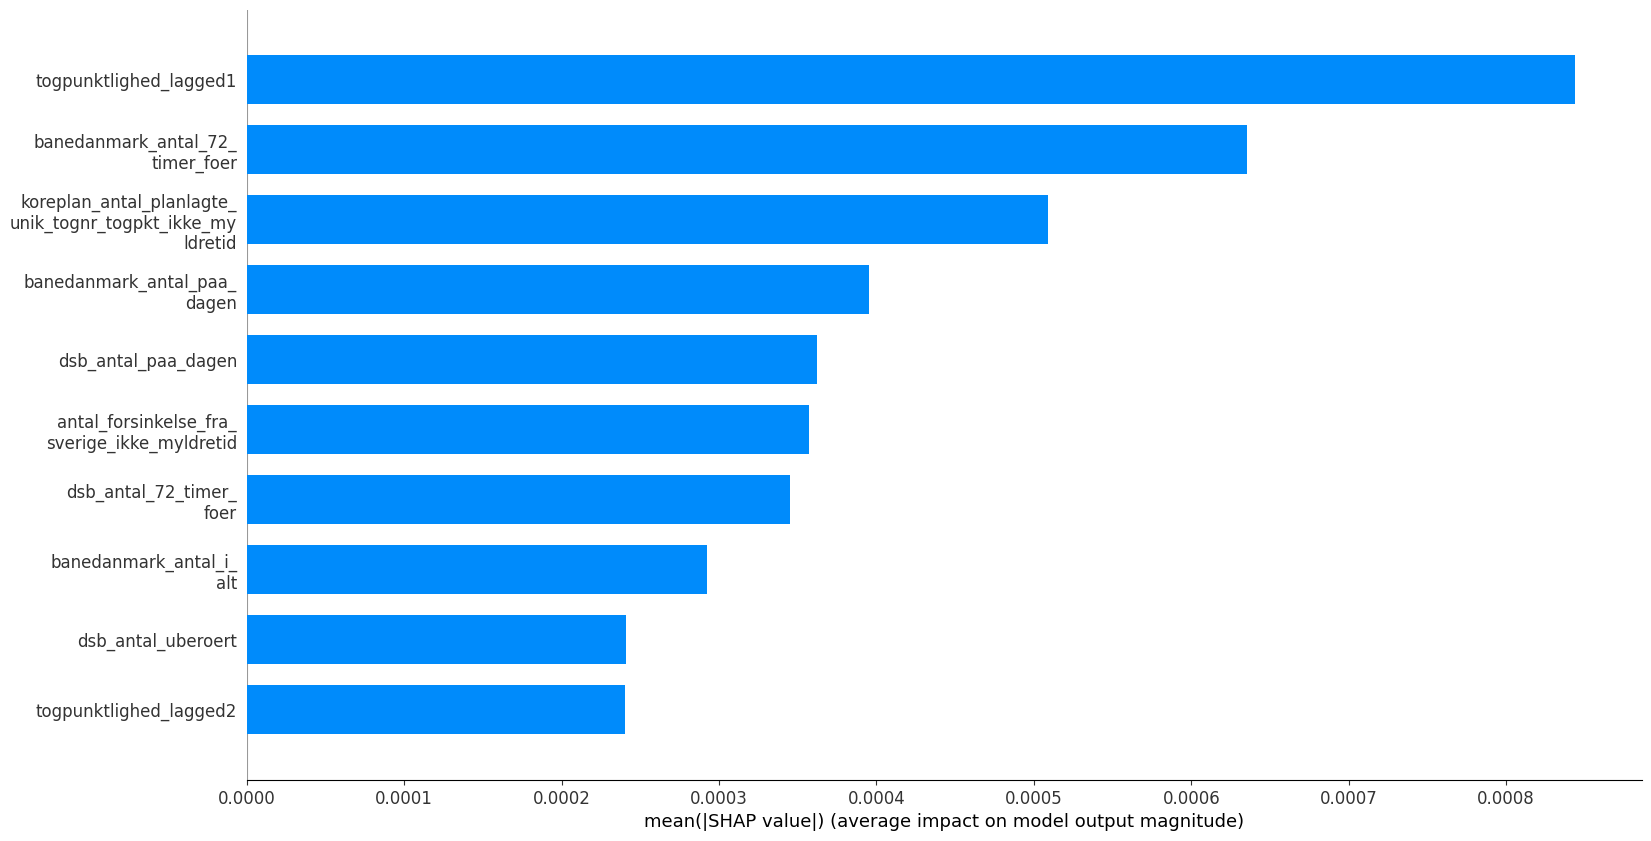

In [56]:
FI_Cleaned_lagged_ARIMA_XGBoost.plot_shap_summary(new_mean_matrix=FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency[:,:,0], plot_type='bar')

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


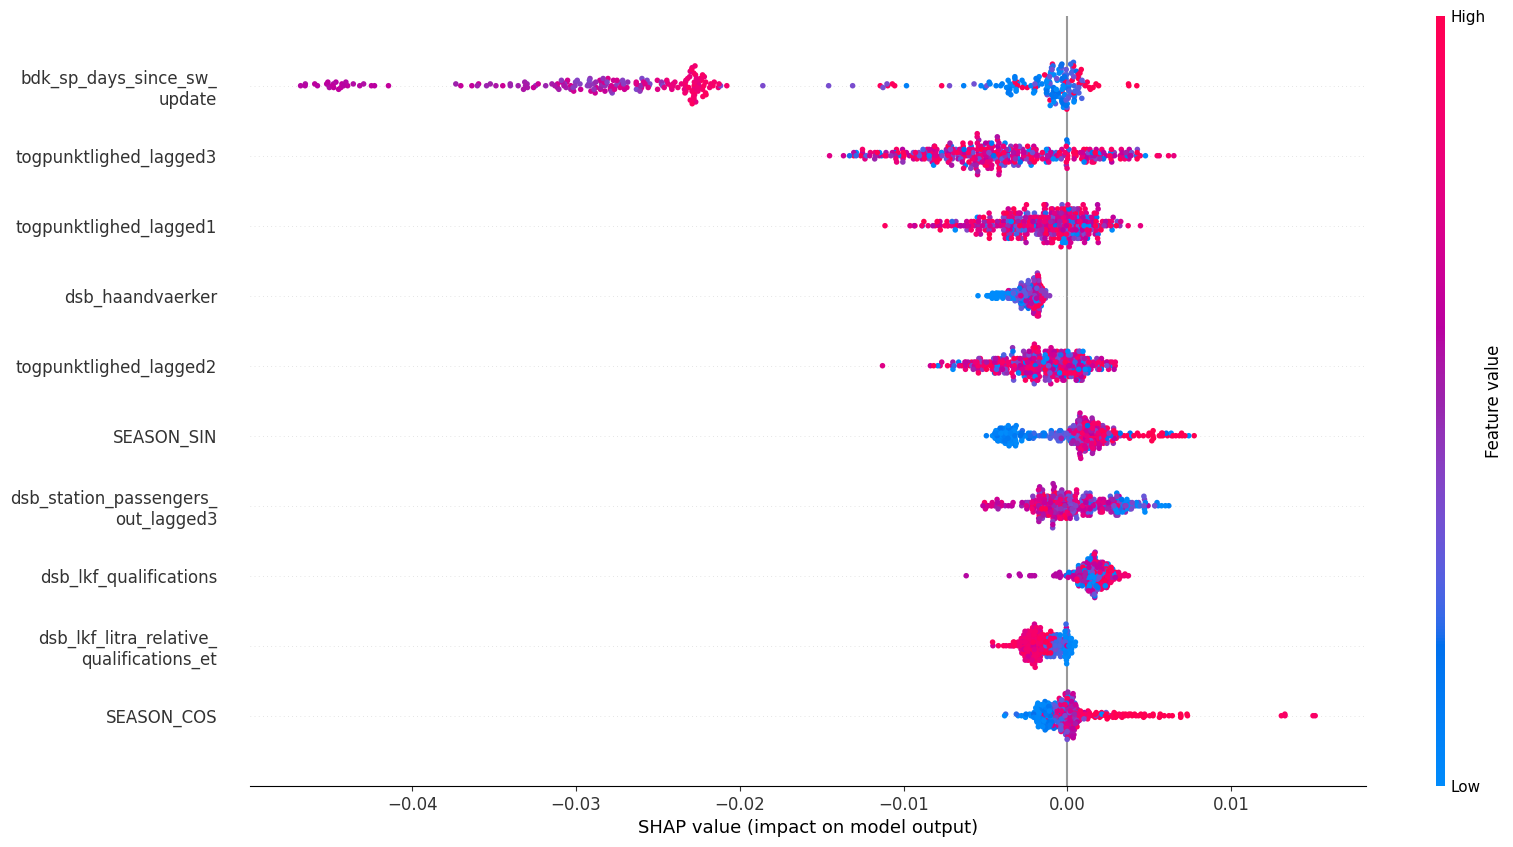

In [57]:
FI_Cleaned_lagged_ARIMA_XGBoost.plot_shap_summary()